**Проект: вариант 3 - дейтинговое приложение.**

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

**Основная цель** - проверить был ли эксперимент успешен в целом.

**Список задач:**

* Проверка корректности и баланса групп
* Очистка и обогащение данных
* Формирование и расчёт метрик
* Статистическая проверка гипотез
* Сегментный анализ и интерпретация


**Описание данных:**

Файлы:
* `users_test` – информация о пользователях в тестовой группе. 
* `users_control_1` – информация о пользователях в первой контрольной группе. 
* `users_control_2` – информация о пользователях во второй контрольной группе.
* `transactions_test` – информация о платежах пользователей в тестовой группе. 
* `transactions_control_1` – информация о платежах пользователей в первой контрольной группе.
* `transactions_control_2` – информация о платежах пользователей во второй контрольной группе


Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). 

Для каждой из них:

**`users_*.csv`** – информация о пользователях:

* `uid` – идентификатор пользователя
* `age` – возраст
* `attraction_coeff` – коэффициент привлекательности (от 0 до 1000,$\frac{\text{просмотры}}{\text{лайки}} \cdot 1000$)
* `coins` – число монеток (внутренняя валюта)
* `country` – страна  
* `visit_days` – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
* `gender` – пол
* `age_filter_start`  – фильтр поиска, мин. значение 
* `age_filter_end`  – фильтр поиска, макс. значение 
* `views_count` – число полученных оценок 
* `was_premium` – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
* `is_premium` –  является ли премиум
* `total_revenue` – нормированная выручка 


**`transactions_*.csv`** – информация о платежах пользователей:

* `uid` – идентификатор пользователя
* `country` – страна
* `joined_at` – дата и время регистрации
* `paid_at` – дата и время покупки
* `revenue` – нормированная выручка
* `payment_id` – идентификатор платежа
* `from_page` – откуда пользователь перешел на страницу оплаты
* `product_type` – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

 

### 1. Загрузка данных и первичный анализ 

#### 1.1 Импорт библиотек и загрузка данных

In [1]:
import io, requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from statsmodels.stats.multitest import multipletests
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
ALPHA       = 0.05                    # уровень значимости
POWER_TGT   = 0.80                    # желаемая мощность
PREMIUM_TPS = ['trial_premium', 'premium_no_trial'] #'trial_premium' - нужен, только для сравнения его в метриках(растет т.к. цена не изменилась)
BOOTSTRAP_SAMPLES = 10_000            # итерации бутстрапа
RNG = np.random.default_rng(seed=42)  # воспроизводимость

In [3]:
# Загрузка файлов из Я.диск

links = {
    "users_test":        "https://disk.yandex.ru/d/4XXIME4osGrMRA",
    "users_control_1":   "https://disk.yandex.ru/d/yJFydMNNGkEKfg",
    "users_control_2":   "https://disk.yandex.ru/d/br6KkQupzzTGoQ",
    "transactions_test": "https://disk.yandex.ru/d/gvCWpZ55ODzs2g",
    "transactions_control_1": "https://disk.yandex.ru/d/VY5W0keMX5TZBQ",
    "transactions_control_2": "https://disk.yandex.ru/d/th5GL0mGOc-qzg",
}

targets = {
    "trans_c1": links["transactions_control_1"],
    "trans_c2": links["transactions_control_2"],
    "trans_t":  links["transactions_test"],
    "users_c1": links["users_control_1"],
    "users_c2": links["users_control_2"],
    "users_t":  links["users_test"],
}

def ydl(url):
    href = requests.get(
        "https://cloud-api.yandex.net/v1/disk/public/resources/download",
        params={"public_key": url}, timeout=30
    ).json()["href"]
    data = requests.get(href, timeout=60).content
    return pd.read_csv(io.BytesIO(data), sep=";", encoding="utf-8-sig")

dfs = {name: ydl(url) for name, url in targets.items()}

trans_c1, trans_c2, trans_t, users_c1, users_c2, users_t = (
    dfs[k] for k in ("trans_c1","trans_c2","trans_t","users_c1","users_c2","users_t")
)

#### 1.2 Первичный осмотр данных 

In [4]:
trans_c1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [5]:
trans_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [6]:
trans_c1.describe()

,uid,revenue,payment_id
count,3.770000e+02,377.000000,377.000000
mean,8.923612e+08,6929.206897,91.145889
std,6.162900e+06,8027.889630,58.599773
min,8.910923e+08,26.000000,0.000000
25%,8.913833e+08,2730.000000,19.000000
50%,8.918225e+08,6266.000000,127.000000
75%,8.921850e+08,6448.000000,147.000000
max,9.609370e+08,63037.000000,147.000000


In [7]:
mask = trans_c1['revenue'] % 1 != 0
mask.sum()

np.int64(630)

1) тип идентификатора пользователя - `uid` ошибочно указан, как float64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип даннхы `revenue` указан как float64, для единообразия и уменьшения объема памяти, заменим его на int64 (значящих цифр после запятой нет)

4) тип идентификатора платежа - `payment_id` ошибочно указан, как float64,необходимо изменить на object

5) таблица имеет 1007 строк, 630 из них пустые

6) пропуски в столбцах `joined_at` и `paid_at` обозначены как "NaT"

7) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее примерно равено медиане, возможно нет больших выбросов. 

In [8]:
trans_c2

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
...,...,...,...,...,...,...,...,...
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium
324,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium
325,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261,19,autorefill,coins
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997,147,trial_vip_popup,trial_premium


In [9]:
trans_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [10]:
trans_c2.describe()

,uid,revenue,payment_id
count,3.280000e+02,328.000000,328.000000
mean,8.918121e+08,5854.993902,95.527439
std,3.802149e+05,6582.242539,57.247832
min,8.910681e+08,481.000000,0.000000
25%,8.915738e+08,2323.750000,19.000000
50%,8.918626e+08,4706.000000,146.000000
75%,8.921281e+08,6314.750000,147.000000
max,8.924388e+08,81796.000000,147.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип идентификатора платежа - `payment_id` ошибочно указан, как int64,необходимо изменить на object

4) на данном этапе пропуски не обнаружены

5) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее меньше медианы, возможно есть выбросы в меньшую сторону.

In [11]:
trans_t

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium
...,...,...,...,...,...,...,...,...
268,891419625,Israel,2017-04-11 05:58:00,2017-11-11 08:33:00,14352,147,trial_vip_popup,trial_premium
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial
270,891497073,United States of America,2017-02-11 15:33:00,2017-05-11 04:06:00,2730,67,empty_likes,other_type
271,891406224,Israel,2017-04-11 12:56:00,2017-04-11 13:35:00,2743,67,empty_likes,other_type


In [12]:
trans_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [13]:
trans_t.describe()

,uid,revenue,payment_id
count,2.730000e+02,273.000000,273.000000
mean,8.918375e+08,8589.380952,98.227106
std,3.777452e+05,11127.479971,57.762760
min,8.910712e+08,533.000000,0.000000
25%,8.915082e+08,2743.000000,19.000000
50%,8.919143e+08,6305.000000,146.000000
75%,8.921442e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип идентификатора платежа - `payment_id` ошибочно указан, как int64,необходимо изменить на object

4) на данном этапе пропуски не обнаружены

5) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее больше медианы, возможно есть выбросы в большую сторону.

In [14]:
users_c1

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,892022304,26,227,NaN,United States of America,NaN,0,23,29,427,NaN,NaN,0
4336,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0
4337,891304722,49,411,NaN,United States of America,1,1,46,52,17,NaN,NaN,0
4338,891302328,27,0,NaN,United States of America,"1,3,5",1,24,30,0,NaN,NaN,0


In [15]:
users_c1['visit_days']

0                                  1,2,3,4,5,6
1                                          1,2
2                       1,2,3,5,6,8,9,11,13,16
3                                    1,2,3,4,5
4            1,2,3,5,6,7,8,9,10,12,15,16,17,19
                         ...                  
4335                                       NaN
4336    1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21
4337                                         1
4338                                     1,3,5
4339                                         1
Name: visit_days, Length: 4340, dtype: object

In [16]:
users_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [17]:
users_c1.shape

(4340, 13)

In [18]:
users_c1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4280 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1324 пропуска 

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (436 и 192) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

In [19]:
users_c2

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0


In [20]:
users_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [21]:
users_c2.shape

(4264, 13)

In [22]:
users_c2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4203 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1364 пропуска 

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (411 и 191) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

In [23]:
users_t

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,891078639,17,895,NaN,United States of America,"1,2,3,4,5",1,16,20,96,NaN,NaN,0
4304,891188733,27,866,NaN,United States of America,"1,2,3",1,18,41,30,NaN,NaN,0
4305,891293718,48,0,NaN,Argentina,NaN,1,47,51,10,NaN,NaN,0
4306,891192357,32,0,NaN,Australia,NaN,1,16,49,0,NaN,NaN,0


In [24]:
users_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [25]:
users_t.shape

(4308, 13)

In [26]:
users_t.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4259 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1330 пропусков

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (408 и 157) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

#### Вывод

**Типы данных** 
- `uid`, `payment_id` — привести к `string` / `object`.  
- Даты (`joined_at`, `paid_at`) — конвертировать в `datetime`.  
- Деньги (`revenue`, `total_revenue`) — каст к `int64` (без дробной части).

**Пропуски** 
* `joined_at`, `paid_at` в transactions_control_1 (≈63 % NaN) - удалить пустые строки
* `coins`, `was_premium`, `is_premium` все users_* таблицы заменить NaN на 0, привести к булевому типу
* `visit_days`все users_* таблицы (≈26 % NaN) заполнить.

**Распределения** 
- `revenue` большие хвосты во всех группах → планировать bootstrap.  
- В `control 2` возможны низовые выбросы, в `test` — верхние.

**Размеры и целостность** 
- `transactions_control_1` — 1007 строк, 630 пустых ⇒ риск «битой» выгрузки.  
- Остальные таблицы выглядят консистентно, но нужны проверки на дубликаты и миграцию `uid` между группами.

**Что делаем перед анализом** 
1. Исправляем типы, обрабатываем пропуски.  
2. Чистим дубликаты и выравниваем окна дат.  
3. Фильтруем/обрезаем выбросы в `revenue`.  
4. Сохраняем очищенные данные для дальнейшего A/B-теста.


### 2. Предобработка данных

#### 2.1 Первичная подготовка данных

Подготовим данные transactions_control_1

In [27]:
# Удалим все строки с пропусками в uid
trans_c1 = trans_c1.dropna(subset=['uid'])

In [28]:
# Преобразуем тип uid и payment_id к object
trans_c1['uid'] = trans_c1['uid'].astype('Int64').astype('object')
trans_c1['payment_id'] = trans_c1['payment_id'].astype('Int64').astype('object')

In [29]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_c1['joined_at'] = pd.to_datetime(trans_c1['joined_at'])
trans_c1['paid_at'] = pd.to_datetime(trans_c1['paid_at'])

In [30]:
# Преобразуем тип данных revenue к Int64
trans_c1['revenue'] = trans_c1['revenue'].astype('Int64')

In [31]:
trans_c1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727,147,trial_vip_popup,trial_premium
1,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,trial_vip_popup,trial_premium
2,891822480,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911,19,none,coins
3,891367521,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456,127,sympathy,other_type
4,892207959,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261,19,empty_likes,coins
...,...,...,...,...,...,...,...,...
372,891556971,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886,68,none,premium_no_trial
373,892052106,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883,147,trial_vip_popup,trial_premium
374,892145004,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919,147,trial_vip_popup,trial_premium
375,891458229,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305,19,menu,coins


In [32]:
trans_c1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    object        
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    Int64         
 5   payment_id    377 non-null    object        
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: Int64(1), datetime64[ns](2), object(5)
memory usage: 26.9+ KB


Подготовим данные transactions_control_2

In [33]:
# Преобразуем тип uid и payment_id к object
trans_c2['uid'] = trans_c2['uid'].astype('object')
trans_c2['payment_id'] = trans_c2['payment_id'].astype('object')

In [34]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_c2['joined_at'] = pd.to_datetime(trans_c2['joined_at'])
trans_c2['paid_at'] = pd.to_datetime(trans_c2['paid_at'])

In [35]:
trans_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    object        
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    object        
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 20.6+ KB


Подготовим данные transactions_test

In [36]:
# Преобразуем тип uid и payment_id к object
trans_t['uid'] = trans_t['uid'].astype('object')
trans_t['payment_id'] = trans_t['payment_id'].astype('object')

In [37]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_t['joined_at'] = pd.to_datetime(trans_t['joined_at'])
trans_t['paid_at'] = pd.to_datetime(trans_t['paid_at'])

In [38]:
trans_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    object        
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    object        
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 17.2+ KB


Подготовим данные users_control_1

In [39]:
# Преобразуем тип uid и payment_id к object
users_c1['uid'] = users_c1['uid'].astype('object')

In [40]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_c1.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [41]:
# Изменим тип was_premium и is_premium на bool
users_c1['was_premium'] = users_c1['was_premium'].astype(bool)
users_c1['is_premium'] = users_c1['is_premium'].astype(bool)

In [42]:
miss = users_c1[users_c1['visit_days'].isna()]
miss

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
9,892046007,49,0,0.0,United States of America,NaN,1,46,52,0,False,False,0
13,891969288,37,0,0.0,France,NaN,1,16,79,0,False,False,0
15,891800556,30,0,0.0,United States of America,NaN,1,27,33,7,False,False,0
16,891606519,53,0,0.0,Spain,NaN,1,50,56,0,False,False,0
20,891702429,28,0,0.0,United Kingdom (Great Britain),NaN,1,42,60,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4312,891902661,22,285,0.0,United States of America,NaN,1,19,25,7,False,False,0
4317,891185523,24,0,0.0,United States of America,NaN,1,21,27,2,False,False,0
4329,891073134,21,0,0.0,Argentina,NaN,1,18,24,0,False,False,0
4334,891189471,33,0,0.0,United States of America,NaN,1,30,36,0,False,False,0


In [43]:
miss_tr = trans_c1.query('uid in @miss["uid"]')
miss_tr

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
25,891142386,Switzerland,2017-08-11 23:02:00,2017-08-11 23:38:00,4680,147,left_sidebar_menu,premium_no_trial
44,891225840,Australia,2017-07-11 07:18:00,2017-07-11 08:16:00,3588,68,none,premium_no_trial
48,891357177,Canada,2017-05-11 09:04:00,2017-12-11 11:05:00,9087,147,trial_vip_popup,trial_premium
68,891292845,Italy,2017-06-11 03:51:00,2017-06-11 03:59:00,1898,68,none,premium_no_trial
110,891174534,Argentina,2017-08-11 07:19:00,2017-11-15 09:19:00,10517,147,trial_vip_popup,trial_premium
127,891382470,France,2017-04-11 21:02:00,2017-04-11 21:05:00,2314,67,empty_likes,other_type
146,892047282,United Arab Emirates,2017-10-22 05:44:00,2017-10-29 07:44:00,10153,147,trial_vip_popup,trial_premium
231,892365015,United Kingdom (Great Britain),2017-10-15 15:32:00,2017-10-23 13:38:00,12727,147,dating,trial_premium
237,892183086,Belgium,2017-10-19 09:06:00,2017-10-26 11:11:00,16913,147,autoreply_message,trial_premium
285,891668241,United States of America,2017-10-29 23:08:00,2017-10-29 23:30:00,6305,19,empty_likes,coins


Так как пропусков в `visit_days` - 1324, а транзакций в них всего 17, а повторяющихся uid - нет, то делаем предположение, что пропуски в `visit_days` можно заменить на 0, если пользователи заходили только в день регистрации

In [44]:
users_c1['visit_days'] = users_c1['visit_days'].fillna('0')

In [45]:
users_c1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,False,False,0
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,False,False,0
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,False,False,0
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,False,False,0
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,False,False,0


In [46]:
users_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   object 
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             4340 non-null   float64
 4   country           4340 non-null   object 
 5   visit_days        4340 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       4340 non-null   bool   
 11  is_premium        4340 non-null   bool   
 12  total_revenue     4340 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 381.6+ KB


Подготовим данные users_control_2

In [47]:
# Преобразуем тип uid и payment_id к object
users_c2['uid'] = users_c2['uid'].astype('object')

In [48]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_c2.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [49]:
# Изменим тип was_premium и is_premium на bool
users_c2['was_premium'] = users_c1['was_premium'].astype(bool)
users_c2['is_premium'] = users_c1['is_premium'].astype(bool)

In [50]:
# Заполним пропуски в visit_days на 0
users_c2['visit_days'] = users_c2['visit_days'].fillna('0')

In [51]:
users_c2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,0.0,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,False,False,0
1,891782112,57,0,0.0,Italy,1,1,54,60,0,False,False,0
2,891110337,30,769,0.0,France,"1,2,3,4,5",1,27,33,13,False,False,0
3,891796320,48,750,0.0,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,False,False,0
4,891880212,54,638,0.0,United States of America,1,1,35,53,94,False,False,0


In [52]:
users_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   object 
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             4264 non-null   float64
 4   country           4264 non-null   object 
 5   visit_days        4264 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       4264 non-null   bool   
 11  is_premium        4264 non-null   bool   
 12  total_revenue     4264 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 374.9+ KB


Подготовим данные users_test

In [53]:
# Преобразуем тип uid и payment_id к object
users_t['uid'] = users_t['uid'].astype('object')

In [54]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_t.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [55]:
# Изменим тип was_premium и is_premium на bool
users_t['was_premium'] = users_t['was_premium'].astype(bool)
users_t['is_premium'] = users_t['is_premium'].astype(bool)

In [56]:
# Заполним пропуски в visit_days на 0
users_t['visit_days'] = users_t['visit_days'].fillna('0')

In [57]:
users_t.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,False,False,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,False,False,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,False,False,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,False,False,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,True,False,0


In [58]:
users_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   object 
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             4308 non-null   float64
 4   country           4308 non-null   object 
 5   visit_days        4308 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       4308 non-null   bool   
 11  is_premium        4308 non-null   bool   
 12  total_revenue     4308 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 378.8+ KB


Посмотрим на временные интервалы в контрольных и тестовой группе

In [59]:
trans_c1.query('joined_at > paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602,146,empty_likes,coins
14,892277877,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897,19,empty_likes,coins
20,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305,19,autorefill,coins
21,891707061,Argentina,2017-10-29 10:54:00,2017-04-11 00:30:00,1261,19,empty_likes,coins
23,891707061,Argentina,2017-10-29 10:54:00,2017-10-11 00:04:00,1261,19,autorefill,coins


In [60]:
trans_c1.query('joined_at > paid_at')['uid'].unique()

array([891721851, 892277877, 892366260, 891707061, 892207959, 891671796,
       891850512, 891693753, 891870786, 891822480, 892136748, 892290105,
       891881343, 892310253, 891662499, 892421277, 892116756, 891653790,
       891568008, 891851568, 891583611, 891765819, 892120956, 891675147,
       892069554, 891616074, 891908385, 891648354, 891705120, 891719682,
       891645606, 891580347, 891622389, 891973917, 891679842, 891972303,
       892145004], dtype=object)

In [61]:
trans_c2.query('joined_at > paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium
19,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:14:00,3783,67,empty_likes,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins


In [62]:
trans_c2.query('joined_at > paid_at')['uid'].unique()

array([892186737, 891592941, 891655107, 891606141, 891609360, 891897387,
       891637005, 891647544, 892354854, 891664350, 892153296, 891938808,
       891592491, 891841425, 892247952, 891722802, 891877569, 892128138,
       891791565, 891937068, 891728889, 891580662, 891878595, 891841752,
       891675498, 891789270, 891632037, 891659976, 892336548, 891728544,
       891672225, 891668253, 891861999, 891789768, 891698172, 891581349,
       891999189, 891932496, 891691062, 892075512, 891673269],
      dtype=object)

In [63]:
trans_t.query('joined_at > paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins


In [64]:
trans_t.query('joined_at > paid_at')['uid'].unique()

array([891861048, 891806280, 891786216, 892057347, 891589239, 892037613,
       892065108, 891640689, 892261437, 891764031, 892275462, 892205850,
       891777708, 891600819, 891861489, 891904293, 891867288, 891654012,
       891861594, 892339626, 891651711, 891986289, 891654090, 891872313,
       891854907, 891603810, 891882681, 891867477, 891769893, 892225122,
       891718167, 891700323, 891818670, 892018248, 891572565],
      dtype=object)

Все даты `paid_at` раньше `joined_at` оканчиваются на 11, есть предположение, что все они 11 - месяца, построим графики распределения дат

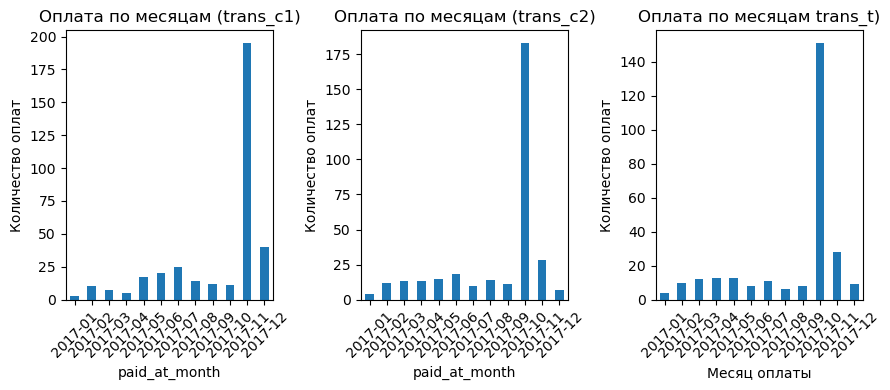

In [65]:
#Построим графики по месяцам

trans_c1['paid_at_month'] = trans_c1['paid_at'].dt.to_period('M')
trans_c2['paid_at_month'] = trans_c2['paid_at'].dt.to_period('M')
trans_t['paid_at_month']  = trans_t['paid_at'].dt.to_period('M')

# Создаём холст из 3 графиков (в столбик)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4), sharex=True)

# График для trans_c1
trans_c1['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0])
axes[0].set_title('Оплата по месяцам (trans_c1)')
axes[0].set_ylabel('Количество оплат')
axes[0].tick_params(axis='x', rotation=45)

# График для trans_c2
trans_c2['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1])
axes[1].set_title('Оплата по месяцам (trans_c2)')
axes[1].set_ylabel('Количество оплат')
axes[1].tick_params(axis='x', rotation=45)

# График для trans_t
trans_t['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[2])
axes[2].set_title('Оплата по месяцам trans_t)')
axes[2].set_xlabel('Месяц оплаты')
axes[2].set_ylabel('Количество оплат')
axes[2].tick_params(axis='x', rotation=45)

# Финальная настройка макета
plt.tight_layout()
plt.show()

In [66]:
# Меняем местами день и месяц для 11 месяца
def swap_day_month_if_day_is_11(dt):
    if dt.day == 11:
        # Меняем местами день и месяц
        return datetime(dt.year, dt.day, dt.month)  # год, новый месяц, новый день
    else:
        return dt

In [67]:
trans_c1['paid_at'] = trans_c1['paid_at'].apply(swap_day_month_if_day_is_11)

In [68]:
trans_c2['paid_at'] = trans_c2['paid_at'].apply(swap_day_month_if_day_is_11)

In [69]:
trans_t['paid_at'] = trans_t['paid_at'].apply(swap_day_month_if_day_is_11)

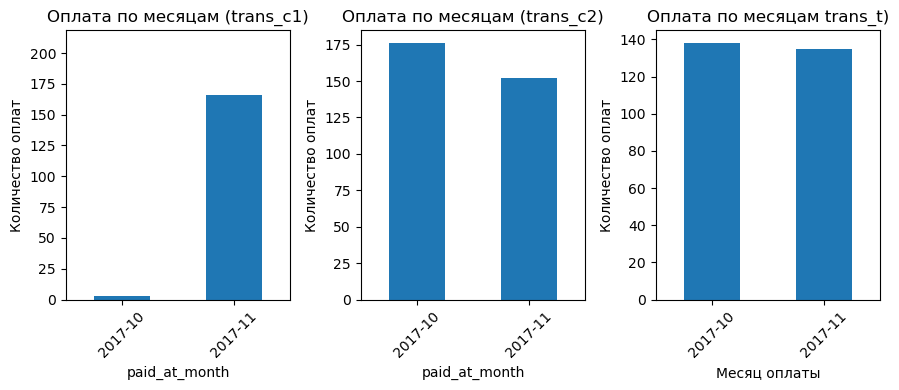

In [70]:
#Построим графики по месяцам

trans_c1['paid_at_month'] = trans_c1['paid_at'].dt.to_period('M')
trans_c2['paid_at_month'] = trans_c2['paid_at'].dt.to_period('M')
trans_t['paid_at_month']  = trans_t['paid_at'].dt.to_period('M')

# Создаём холст из 3 графиков (в столбик)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4), sharex=True)

# График для trans_c1
trans_c1['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0])
axes[0].set_title('Оплата по месяцам (trans_c1)')
axes[0].set_ylabel('Количество оплат')
axes[0].tick_params(axis='x', rotation=45)

# График для trans_c2
trans_c2['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1])
axes[1].set_title('Оплата по месяцам (trans_c2)')
axes[1].set_ylabel('Количество оплат')
axes[1].tick_params(axis='x', rotation=45)

# График для trans_t
trans_t['paid_at_month'].value_counts().sort_index().plot(
    kind='bar', ax=axes[2])
axes[2].set_title('Оплата по месяцам trans_t)')
axes[2].set_xlabel('Месяц оплаты')
axes[2].set_ylabel('Количество оплат')
axes[2].tick_params(axis='x', rotation=45)

# Финальная настройка макета
plt.tight_layout()
plt.show()

In [71]:
trans_c1.query('joined_at > paid_at')['uid'].unique()
trans_c2.query('joined_at > paid_at')['uid'].unique()
trans_t.query('joined_at > paid_at')['uid'].unique()

array([], dtype=object)

Даты распределились между 10 и 11 месяцами, больше нет дат присоединения после оплаты

Ограничим интервалы контрольной группы минимум и максимумом тестовой группы

In [72]:
# Находим «окно рекрутирования» по тесту
JOIN_MIN = trans_t['joined_at'].min()   # 2017-01-11
JOIN_MAX = trans_t['joined_at'].max()   # 2017-10-31
print('Окно joined_at:', JOIN_MIN.date(), '…', JOIN_MAX.date())

Окно joined_at: 2017-01-11 … 2017-10-31


In [73]:
# Оставляем ТОЛЬКО транзакции с joined_at в этом окне
trans_c1 = trans_c1.query('@JOIN_MIN <= joined_at <= @JOIN_MAX')
trans_c2 = trans_c2.query('@JOIN_MIN <= joined_at <= @JOIN_MAX')
trans_t  = trans_t .query('@JOIN_MIN <= joined_at <= @JOIN_MAX')

In [74]:
# Ограничиваем paid_at тем же global window
TEST_START = trans_t['paid_at'].min() # 2017-10-14
TEST_END = trans_t['paid_at'].max() # 2017-11-15
trans_c1 = trans_c1.query('@TEST_START <= paid_at <= @TEST_END')
trans_c2 = trans_c2.query('@TEST_START <= paid_at <= @TEST_END')
trans_t  = trans_t .query('@TEST_START <= paid_at <= @TEST_END')
print('Окно paid_at:', TEST_START.date(), '…', TEST_END.date())

Окно paid_at: 2017-10-14 … 2017-11-15


Так же посмотрим на распределение `revenue` и `total_revenue` т.к. на первичном осомтре данных были заметны смещения

In [75]:
datasets = [
    ("trans_c1['revenue']", trans_c1['revenue'].dropna()),
    ("trans_c2['revenue']", trans_c2['revenue'].dropna()),
    ("trans_t['revenue']",  trans_t['revenue'].dropna()),
    ("users_c1['total_revenue']", users_c1['total_revenue'].dropna()),
    ("users_c2['total_revenue']", users_c2['total_revenue'].dropna()),
    ("users_t['total_revenue']",  users_t['total_revenue'].dropna()),
]

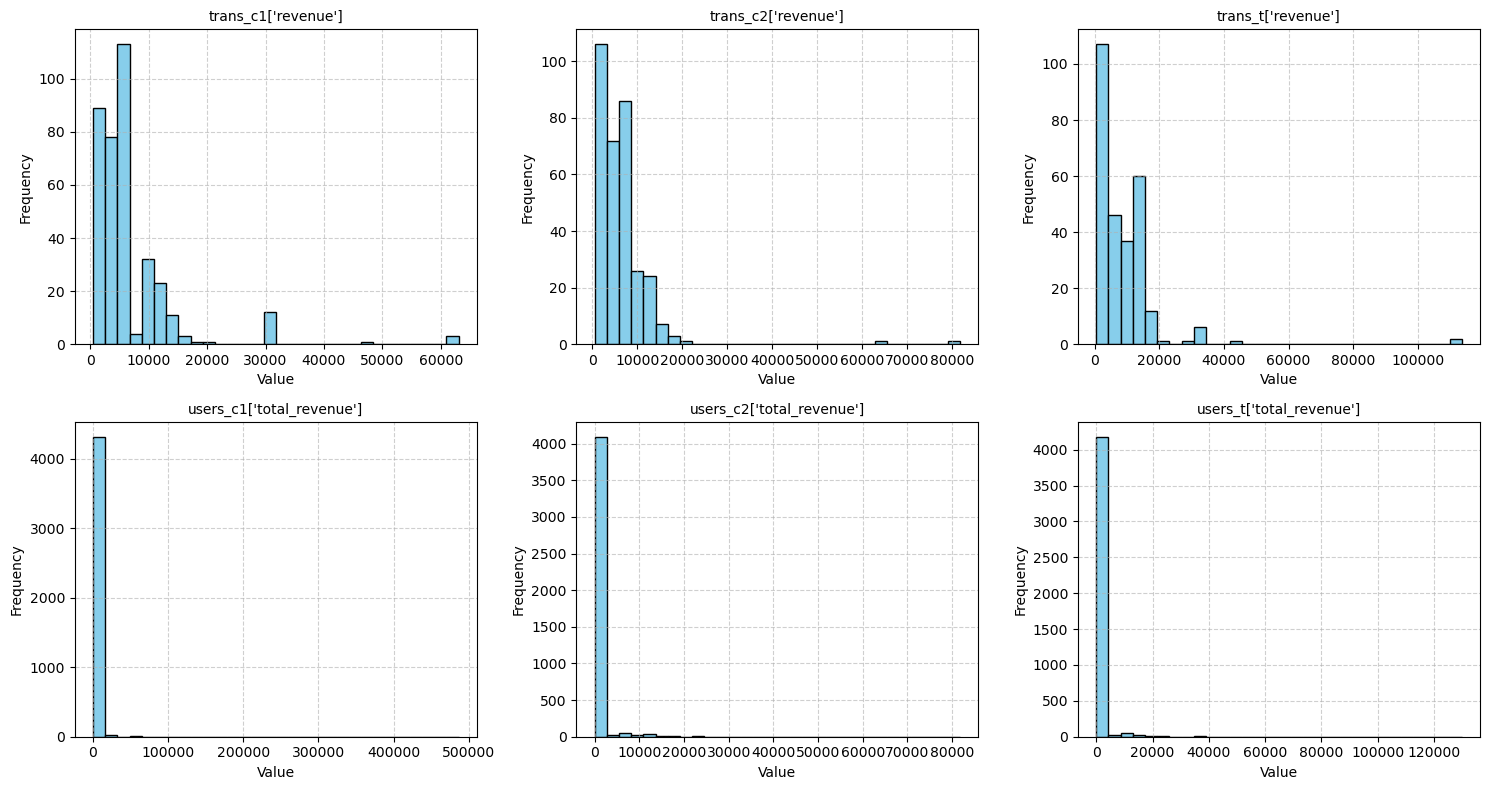

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (label, data) in zip(axes, datasets):
    ax.hist(data, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(label, fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Графики явно имеюне не нормальное распределение, нарушены предпосылки нормальности и равенства дисперсий. Нужно использовать непараметрические тесты или провести лог-трансформацию.

Построим гистограммы логарифмированных распределений

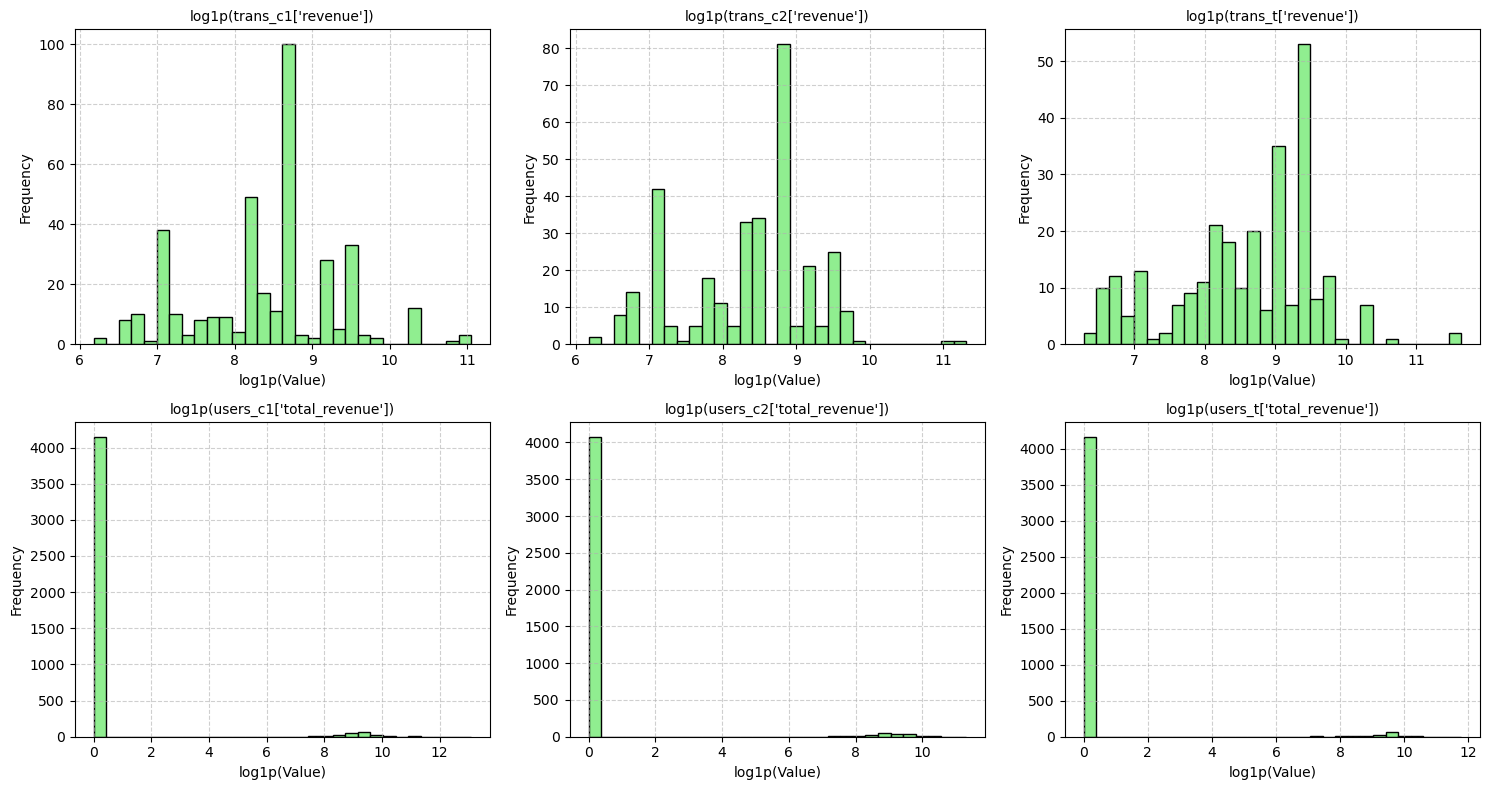

In [77]:
# Логарифмируем данные: log(1 + x)
log_datasets = [
    (label, np.log1p(data)) for label, data in datasets
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (label, data) in zip(axes, log_datasets):
    ax.hist(data, bins=30, color='lightgreen', edgecolor='black')
    ax.set_title(f"log1p({label})", fontsize=10)
    ax.set_xlabel('log1p(Value)')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

После логарифмирования, значения `revenue` стали больше походить на нормальное распределение, но значения `total_revenue` из-за большого количества 0 значений, все еще не похоже на нормальное распределение. 

Проверим данные на дубликаты и кросс пересечения

In [78]:
# Дубликаты внутри USERS-файлов
dups_uc1 = users_c1[users_c1.duplicated('uid', keep=False)]
dups_uc2 = users_c2[users_c2.duplicated('uid', keep=False)]
dups_ut  = users_t [users_t.duplicated('uid', keep=False)]

print(f'uc1: {len(dups_uc1)} строк  ({dups_uc1["uid"].nunique()} уникальных uid)')
print(f'uc2: {len(dups_uc2)} строк  ({dups_uc2["uid"].nunique()} уникальных uid)')
print(f'ut : {len(dups_ut )} строк  ({dups_ut ["uid"].nunique()} уникальных uid)')

uc1: 0 строк  (0 уникальных uid)
uc2: 0 строк  (0 уникальных uid)
ut : 0 строк  (0 уникальных uid)


In [79]:
WIN = timedelta(minutes=5)         # окно «почти-дубля» (5 минут)

# цикл по трём DataFrame ---
for name, df in [('trans_c1', trans_c1), ('trans_c2', trans_c2), ('trans_t', trans_t)]:
    # Полные дубли — совпадают ВСЕ столбцы
    full_dups = df.duplicated(keep=False)
    n_full = full_dups.sum()

    # «Почти» дубли — те же uid + payment_id + revenue,
    # но paid_at отличается ≤ 5 минут
    df_sorted = df.sort_values(['uid', 'payment_id', 'revenue', 'paid_at'])
    time_diff = (
        df_sorted
          .groupby(['uid', 'payment_id', 'revenue'])['paid_at']
          .diff()
    )
    near_dups = time_diff.notna() & (time_diff <= WIN)
    n_near = near_dups.sum()

    print(f'{name}: {n_full} строк-клонов (полных) | '
          f'{n_near} строк в окне ≤5 мин при тех же uid+payment_id+revenue')

trans_c1: 47 строк-клонов (полных) | 38 строк в окне ≤5 мин при тех же uid+payment_id+revenue
trans_c2: 19 строк-клонов (полных) | 24 строк в окне ≤5 мин при тех же uid+payment_id+revenue
trans_t: 20 строк-клонов (полных) | 15 строк в окне ≤5 мин при тех же uid+payment_id+revenue


In [80]:
# все строки, которые точь-в-точь повторяют другую
dup_rows_tc1 = trans_c1[trans_c1.duplicated(keep=False)].sort_values(
    ['uid', 'payment_id', 'paid_at']
)

print(f'Найдено {len(dup_rows_tc1)} полных дублей — показываю ниже ↓')
dup_rows_tc1

Найдено 47 полных дублей — показываю ниже ↓


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,paid_at_month
18,891135642,Chile,2017-09-11 03:14:00,2017-11-10 00:00:00,481,19,none,coins,2017-11
265,891135642,Chile,2017-09-11 03:14:00,2017-11-10 00:00:00,481,19,none,coins,2017-11
341,891252072,Argentina,2017-06-11 19:56:00,2017-11-08 00:00:00,1261,19,empty_likes,coins,2017-11
344,891252072,Argentina,2017-06-11 19:56:00,2017-11-08 00:00:00,1261,19,empty_likes,coins,2017-11
17,891254103,United Arab Emirates,2017-06-11 19:19:00,2017-11-10 00:00:00,1261,19,empty_likes,coins,2017-11
144,891254103,United Arab Emirates,2017-06-11 19:19:00,2017-11-10 00:00:00,1261,19,empty_likes,coins,2017-11
227,891320916,Israel,2017-05-11 19:36:00,2017-11-07 00:00:00,3783,67,empty_likes,other_type,2017-11
301,891320916,Israel,2017-05-11 19:36:00,2017-11-07 00:00:00,3783,67,empty_likes,other_type,2017-11
22,891365490,United States of America,2017-05-11 03:55:00,2017-11-06 00:00:00,1261,19,empty_likes,coins,2017-11
233,891365490,United States of America,2017-05-11 03:55:00,2017-11-06 00:00:00,1261,19,empty_likes,coins,2017-11


In [81]:
# Функция дедуплекации
def dedup_tx(df):
    # убираем дубли
    df = df.drop_duplicates(keep='first').copy()

    # сортируем
    df.sort_values(['uid', 'payment_id', 'revenue', 'paid_at'],
                   inplace=True)

    # флаг «это дубль, т.к. в пределах WIN»
    mask = (
        df.groupby(['uid', 'payment_id', 'revenue'])['paid_at']
          .diff()                       # разница с предыдущей строкой в группе
          .le(WIN)                      # True, если ≤ 5 мин
    )

    # оставляем строки, где mask не True (т.е. первая в кластере)
    return df[~mask.fillna(False)]

In [82]:
# Удалим все дубли, из похожих транзакций в рамках 5 минут, оставим 1
trans_c1 = dedup_tx(trans_c1)
trans_c2 = dedup_tx(trans_c2)
trans_t  = dedup_tx(trans_t)

In [83]:
# Пересечения uid между группами
inter_uc1_uc2 = set(users_c1['uid']) & set(users_c2['uid'])
inter_uc1_ut  = set(users_c1['uid']) & set(users_t ['uid'])
inter_uc2_ut  = set(users_c2['uid']) & set(users_t ['uid'])

print(f'users_c1 ∩ users_c2: {len(inter_uc1_uc2)}')
print(f'users_c1 ∩ users_t : {len(inter_uc1_ut )}')
print(f'users_c2 ∩ users_t : {len(inter_uc2_ut )}')

users_c1 ∩ users_c2: 0
users_c1 ∩ users_t : 0
users_c2 ∩ users_t : 0


Ограничим по странам, что бы в контроле и тесте были одни и теже страны 

In [84]:
countries_tc1_tc2 = set(trans_c1['country']).union(trans_c2['country'])

In [85]:
common_countries = set(trans_t['country']).intersection(countries_tc1_tc2)

In [86]:
common_countries

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'France',
 'Germany',
 'Israel',
 'Italy',
 'Spain',
 'Switzerland',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

Portugal, Ukraine, India, Australia в контроле, всего 18 стран, в тесте Latvia и Mexico, всего 16 стран - общих стран - 14

In [87]:
trans_c1 = trans_c1[trans_c1['country'].isin(common_countries)]
trans_c2 = trans_c2[trans_c2['country'].isin(common_countries)]
trans_t  = trans_t[trans_t['country'].isin(common_countries)]

**Типы и пропуски**
* `uid`, `payment_id` приведены к типу `object`; даты `joined_at`/`paid_at` — к `datetime64`; денежные поля — к целым (`Int64`/`int`).
* В `transactions_control_1` удалены строки с пустым `uid`: из 1007 строк осталось 377 валидных.
* В `users_*`: `coins`, `was_premium`, `is_premium` заполнены нулями; `was_premium` и `is_premium` приведены к `bool`.
* `visit_days`: пропуски заменены на '0' (однодневный визит). Обоснование — среди 1324 пропусков в `users_c1` найдено лишь 17 транзакций и 0 повторов `uid`, значит вероятнее всего это пользователи с единственным визитом в день регистрации.

**Аномалия дат и её исправление (месяц 11)**
* Обнаружены записи, где `paid_at` < `joined_at`, и все такие `paid_at` оканчивались на 11.
* Гистограммы по месяцам показали «сдвиг», характерный для перепутанных дня и месяца.
* Исправление: для строк с днём = 11 произведена перестановка «день ↔ месяц» (11 трактуем как ноябрь).
* После фикса распределение paid_at корректно сосредоточено в октябре–ноябре (10–11 месяцы).

**Окна рекрутирования/наблюдения**
* Окно регистрации по тесту: 2017-01-11 … 2017-10-31. Контрольные транзакции ограничены тем же окном `joined_at`.
* Окно оплат по тесту: 2017-10-14 … 2017-11-15. Контрольные оплаты ограничены тем же интервалом `paid_at`.
* Зачем: синхронизируем горизонты, чтобы избежать смещений выживаемости/сезонности.

**Дубликаты и «почти дубликаты»**
* Полные дубли (совпадают все поля) и «почти дубли» (те же uid+payment_id+revenue, но paid_at ≤ 5 минут) найдены и удалены:
* `trans_c1`: 47 полных, 38 «≤5 мин»
* `trans_c2`: 19 полных, 24 «≤5 мин»
* `trans_t`: 20 полных, 15 «≤5 мин**
* Оставлена первая запись в каждом кластере (функция dedup_tx).

**Целостность по пользователям**
* Внутри `users_*` дубликатов `uid` нет.
* Между группами пересечений `uid` нет (`control_1` ∩ `control_2` ∩ `test` = ∅).

**Страны**
* Сформирован список общих стран между контролем и тестом: 14 стран.
* Примеры «только в контроле»: `Portugal`, `Ukraine`, `India`; «только в тесте»: `Latvia`, `Mexico`.
* `transactions_*` отфильтрованы по общему пересечению стран, чтобы сравнения были сопоставимы.

**Распределения денег**
* `revenue` и `total_revenue` имеют тяжёлые хвосты; лог-трансформация (log1p) делает revenue ближе к нормальному, но `total_revenue` остаётся сильно нулевым (zero-inflated).
* Вывод: для денег используем непараметрические тесты/бутстреп и (дополнительно) анализ на лог-шкале.

⸻

**Итог:** данные очищены, синхронизированы по времени, дедуплицированы и выровнены по странам; можно надёжно считать метрики и запускать статистические сравнения.

### 3. Создание новых признаков и расчёты

#### 3.1 Создание новых признаков

Создадим переменную `visits_n`  - суммарное количество визитов

In [88]:
users_c1['visits_n'] = (
    users_c1['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

In [89]:
users_c2['visits_n'] = (
    users_c2['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

In [90]:
users_t['visits_n'] = (
    users_t['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

#### 3.2 Проверка контрольных групп (A/A)

Проверим контрольные группы на равенство средних.

Так как дублей и пересечений нет, то в случае равенства объединим tc1 с tc2  и uc1 с uc2.

In [91]:
def _succ_fail(users: pd.DataFrame, trans: pd.DataFrame, premium_tps=PREMIUM_TPS):
    uid_pay = set(trans[trans['product_type'].isin(premium_tps)]['uid'])
    succ = sum(users['uid'].isin(uid_pay))
    fail = len(users) - succ
    return succ, fail

In [92]:
def _p_prop_test(succ_a, fail_a, succ_b, fail_b):
    # Явная 2×2: строки — группы, столбцы — [success, fail]
    table = np.array([[succ_a, fail_a],
                      [succ_b, fail_b]], dtype=int)
    # Если где-то очень мало наблюдений — Fisher
    if (table < 5).any():
        _, p = st.fisher_exact(table, alternative='two-sided')
    else:
        _, p, _, _ = st.chi2_contingency(table, correction=False)
    return p

In [93]:
def _arpu_vector(users: pd.DataFrame, trans: pd.DataFrame, premium_tps=PREMIUM_TPS):
    rev = (trans[trans['product_type'].isin(premium_tps)]
            .groupby('uid')['revenue'].sum())
    full = pd.Series(0, index=users['uid'], dtype=int)
    full.update(rev)
    return full.values

In [94]:
def _p_arpu_mw(users_a, trans_a, users_b, trans_b):
    a = _arpu_vector(users_a, trans_a)
    b = _arpu_vector(users_b, trans_b)
    # Нераспр. метрика → Манн–Уитни
    _, p = st.mannwhitneyu(a, b, alternative='two-sided')
    return p, a.mean(), b.mean()

In [95]:
def _p_mw(series_a, series_b):
    # общий хелпер для непрерывных распределений
    _, p = st.mannwhitneyu(series_a, series_b, alternative='two-sided')
    return p

In [96]:
def _p_gender(users_a, users_b):
    male_a = (users_a['gender'] == 1).sum()
    male_b = (users_b['gender'] == 1).sum()
    fem_a  = len(users_a) - male_a
    fem_b  = len(users_b) - male_b
    table = np.array([[male_a, fem_a],
                      [male_b, fem_b]], dtype=int)
    if (table < 5).any():
        _, p = st.fisher_exact(table, alternative='two-sided')
    else:
        _, p, _, _ = st.chi2_contingency(table, correction=False)
    return p

In [97]:
def _p_country(users_a, users_b):
    # χ² по распределению стран (объединяем редкие хвосты)
    vc_a = users_a['country'].value_counts()
    vc_b = users_b['country'].value_counts()
    idx = list(set(vc_a.index) | set(vc_b.index))
    a = vc_a.reindex(idx, fill_value=0).values
    b = vc_b.reindex(idx, fill_value=0).values
    table = np.vstack([a, b])
    # Слишком разреженные таблицы можно аккуратно агрегировать вручную при желании
    _, p, _, _ = st.chi2_contingency(table, correction=False)
    return p

In [98]:

def check_balance(users_a, trans_a, users_b, trans_b, name_a='A', name_b='B'):
    # 1) Продуктовые метрики
    succ_a, fail_a = _succ_fail(users_a, trans_a)
    succ_b, fail_b = _succ_fail(users_b, trans_b)
    p_cr = _p_prop_test(succ_a, fail_a, succ_b, fail_b)
    p_arpu, arpu_a, arpu_b = _p_arpu_mw(users_a, trans_a, users_b, trans_b)

    # Доля trial среди покупателей
    def _trial_share(users, trans):
        paid = trans[trans['product_type'].isin(PREMIUM_TPS)]
        buyers = paid['uid'].nunique()
        if buyers == 0:
            return 0.0, np.nan
        share = (paid['product_type'] == 'trial_premium').mean()
        return share, buyers
    trial_a, buyers_a = _trial_share(users_a, trans_a)
    trial_b, buyers_b = _trial_share(users_b, trans_b)
    # χ² по структуре trial/no_trial среди покупателей (если хватает наблюдений)
    def _p_trial_mix(trans_a, trans_b):
        a = trans_a[trans_a['product_type'].isin(PREMIUM_TPS)]['product_type'].value_counts()
        b = trans_b[trans_b['product_type'].isin(PREMIUM_TPS)]['product_type'].value_counts()
        idx = list(set(a.index) | set(b.index))
        tab = np.vstack([a.reindex(idx, fill_value=0).values,
                         b.reindex(idx, fill_value=0).values])
        if (tab < 5).any():
            return np.nan
        _, p, _, _ = st.chi2_contingency(tab, correction=False)
        return p
    p_trial = _p_trial_mix(trans_a, trans_b)
    # 2) Демография/поведение
    p_gender = _p_gender(users_a, users_b)
    p_age    = _p_mw(users_a['age'], users_b['age'])
    p_attr   = _p_mw(users_a['attraction_coeff'], users_b['attraction_coeff'])
    p_visits = _p_mw(users_a['visits_n'], users_b['visits_n'])
    p_country = _p_country(users_a, users_b)

    rows = [
        ['CR (конверсия в premium)',       p_cr,   succ_a/len(users_a), succ_b/len(users_b)],
        ['ARPU (на пользователя)',         p_arpu, arpu_a,               arpu_b],
        ['Trial share (среди покупателей)',p_trial,trial_a,              trial_b],
        ['Пол (share male)',               p_gender,(users_a['gender']==1).mean(), (users_b['gender']==1).mean()],
        ['Возраст (распр.)',               p_age,  users_a['age'].median(), users_b['age'].median()],
        ['Attraction coeff (распр.)',      p_attr, users_a['attraction_coeff'].median(), users_b['attraction_coeff'].median()],
        ['Визиты (распр.)',                p_visits,users_a['visits_n'].median(), users_b['visits_n'].median()],
        ['Страны (распр.)',                p_country, np.nan, np.nan],
    ]
    out = pd.DataFrame(rows, columns=['metric','p_value', f'{name_a}_stat',f'{name_b}_stat'])
    # FDR на всякий случай только для демо-метрик (не для продуктовых)
    mask = out['metric'].isin(['Пол (share male)','Возраст (распр.)','Attraction coeff (распр.)','Визиты (распр.)','Страны (распр.)'])
    out.loc[mask, 'p_value_adj'] = multipletests(out.loc[mask, 'p_value'].fillna(1.0), method='fdr_bh')[1]
    return out

In [99]:
# A/A: control_1 vs control_2
aa_report = check_balance(users_c1, trans_c1, users_c2, trans_c2, name_a='control_1', name_b='control_2')
display(aa_report)


,metric,p_value,control_1_stat,control_2_stat,p_value_adj
0,CR (конверсия в premium),0.475096,0.037097,0.034240,NaN
1,ARPU (на пользователя),0.468877,349.319585,309.527439,NaN
2,Trial share (среди покупателей),0.363684,0.389222,0.340000,NaN
3,Пол (share male),0.389717,0.958065,0.954268,0.649529
4,Возраст (распр.),0.791929,30.000000,30.000000,0.791929
5,Attraction coeff (распр.),0.687601,238.500000,250.000000,0.791929
6,Визиты (распр.),0.083984,2.000000,2.000000,0.419918
7,Страны (распр.),0.279095,NaN,NaN,0.649529


In [100]:
if (aa_report.loc[aa_report['metric']=='CR (конверсия в premium)','p_value'].iloc[0] > ALPHA and
    aa_report.loc[aa_report['metric']=='ARPU (на пользователя)','p_value'].iloc[0] > ALPHA):
    print('Контроли эквивалентны по ключевым метрикам → объединяем.')
    control_users = pd.concat([users_c1, users_c2], ignore_index=True)
    control_trans = pd.concat([trans_c1 , trans_c2 ], ignore_index=True)
else:
    raise SystemExit('Контроли различаются по ключевым метрикам — объединять нельзя.')

Контроли эквивалентны по ключевым метрикам → объединяем.


In [101]:
# Баланс TEST vs CONTROL(1+2): проверка только демографии/поведения 
balance_report = check_balance(control_users, control_trans, users_t, trans_t,
                               name_a='control_1+2', name_b='test')

In [102]:
# Скрыть продуктовые p-values (тут нас интересует баланс, а не эффект)
balance_report.loc[balance_report['metric'].str.contains('CR|ARPU|Trial'), ['p_value','p_value_adj']] = np.nan
display(balance_report)

,metric,p_value,control_1+2_stat,test_stat,p_value_adj
0,CR (конверсия в premium),NaN,0.035681,0.029016,NaN
1,ARPU (на пользователя),NaN,329.599256,368.040622,NaN
2,Trial share (среди покупателей),NaN,0.365931,0.451852,NaN
3,Пол (share male),0.426335,0.956183,0.953110,0.710559
4,Возраст (распр.),0.308254,30.000000,30.000000,0.710559
5,Attraction coeff (распр.),0.748488,243.000000,250.000000,0.748488
6,Визиты (распр.),0.331264,2.000000,2.000000,0.710559
7,Страны (распр.),0.668958,NaN,NaN,0.748488


1. A/A (control_1 vs control_2)
* Все p-value для CR, ARPU и Trial share ≫ 0.05 → статистически значимых различий нет.
* Демографические метрики тоже без сигналов.
* Значит, контроли эквивалентны → можно смело объединять.

2. Баланс test vs control(1+2)
* Все демографические p-value тоже далеко от 0.05 → перекосов по полу, возрасту, attraction, визитам и странам нет.
* Это значит, что тестовая и контрольная группы хорошо сбалансированы по ключевым признакам, и можно честно оценивать эффект.

У теста Trial share среди покупателей выше (0.45 против 0.37 в контроле), но мы здесь его не тестировали статистически, потому что этот показатель уже относится к продуктовому эффекту, а не к проверке баланса. Это мы посмотрим на шаге анализа A/B.


#### 3.3 Посмотрим на платежные системы 

In [103]:
prem_control = control_trans.query('product_type == "premium_no_trial"')

In [104]:
prem_test = trans_t.query('product_type == "premium_no_trial"')

In [105]:
prem_test['payment_id'].value_counts()

payment_id
147    61
68     12
0       1
Name: count, dtype: int64

In [106]:
prem_control['payment_id'].value_counts()

payment_id
147    172
68      26
0        3
Name: count, dtype: int64

In [107]:
payment_countries = (
    prem_control
    .groupby(['country','payment_id'])['revenue']
    .mean()
    .reset_index(name='avg_revenue')
)


In [108]:
payment_test = (
    prem_test
    .groupby(['country','payment_id'])['revenue']
    .mean()
    .reset_index(name='avg_revenue')
)


In [109]:
payment_compare = (
    payment_test
    .merge(payment_countries, on=['country', 'payment_id'], suffixes=('_test', '_control'))
)

In [110]:
payment_compare['diff'] = payment_compare['avg_revenue_test'] - payment_compare['avg_revenue_control']
payment_compare['pct_diff'] = (payment_compare['diff'] / payment_compare['avg_revenue_control']) * 100

In [111]:
payment_compare.sort_values('pct_diff', ascending=False)

,country,payment_id,avg_revenue_test,avg_revenue_control,diff,pct_diff
1,Australia,147,12597.000000,4719.0,7878.0,166.942149
12,Spain,147,24918.833333,9692.3125,15226.520833,157.098947
9,Israel,147,12597.000000,6030.916667,6566.083333,108.87372
2,Belgium,147,12597.000000,6348.333333,6248.666667,98.430034
0,Argentina,147,9882.600000,5986.5,3896.1,65.081433
14,United Arab Emirates,147,25789.833333,16433.857143,9355.97619,56.931103
17,United States of America,68,6099.600000,3895.666667,2203.933333,56.573971
4,Canada,147,8651.500000,5763.333333,2888.166667,50.112782
5,Chile,147,8181.333333,5825.3,2356.033333,40.444841
18,United States of America,147,9016.800000,7297.814815,1718.985185,23.554793


Можем оставить только `payment_id` 147 и 68

In [112]:
control_trans = prem_control.query('payment_id in [68,147]')

In [113]:
trans_t = prem_test.query('payment_id in [68,147]')

* В данных фактически две системы — по полю payment_id: 147 и 68. Они же доминируют по всем премиальным покупкам (test: 147 — 61 транз., 68 — 12; control: 147 — 172, 68 — 26), т.е. 147 — основной канал.
* 147: в тесте средний чек по странам значимо выше контроля (на множестве рынков: ES +157%, AU +167%, IL +109%, CA +50%, US +23%, UK +23% и т.д.). Это консистентно с повышением цены. Но при этом CR по пользователям упал значимо: ΔCR = −0.606 п.п., p=0.0127 (FDR p=0.0253). Именно 147 вносит основной вклад в общее падение конверсии.
* 68: изменений по чеку почти нет (в основном +0…+2%, исключение — USA +56% на очень малом N), и по CR эффект незначим: ΔCR = −0.116 п.п., p=0.223. Вывод — либо конфиг/цена для 68 менялись не так, либо просто не хватает мощности (мало транзакций).

#### 3.4 Ключевые метрики по premium_no_trial и payment_id 68,147

In [114]:
def arpu_vector(users: pd.DataFrame, trans: pd.DataFrame) -> np.ndarray:
    rev = trans.groupby("uid")["revenue"].sum()
    full = pd.Series(0, index=users["uid"], dtype=float)
    full.update(rev)
    return full.values

In [115]:
def arppu_vector(users: pd.DataFrame, trans: pd.DataFrame) -> np.ndarray:
    rev = trans.groupby("uid")["revenue"].sum()
    payers = rev[rev > 0]
    return payers.values.astype(float)

In [116]:
def cr_vector(users: pd.DataFrame, trans: pd.DataFrame) -> np.ndarray:
    buyers = set(trans["uid"].unique())
    return users["uid"].isin(buyers).astype(int).values

In [117]:
def bootstrap_ci_and_p(a: np.ndarray, b: np.ndarray, n_boot=BOOTSTRAP_SAMPLES, alpha=ALPHA, rng=RNG):
    """CI для разницы средних (b-a) + корректный двусторонний p_boot: 2*min(frac>0, frac<0)."""
    if len(a)==0 or len(b)==0:
        return (np.nan, np.nan, np.nan)
    diffs = np.empty(n_boot)
    na, nb = len(a), len(b)
    for i in range(n_boot):
        sa = a[rng.integers(0, na, na)]
        sb = b[rng.integers(0, nb, nb)]
        diffs[i] = sb.mean() - sa.mean()
    lo = np.percentile(diffs, 100*(alpha/2))
    hi = np.percentile(diffs, 100*(1-alpha/2))
    frac_pos = (diffs > 0).mean()
    frac_neg = (diffs < 0).mean()
    p_boot = 2 * min(frac_pos, frac_neg)
    return (lo, hi, p_boot)

In [118]:
# векторы
arpu_c = arpu_vector(control_users, control_trans)
arpu_t = arpu_vector(users_t,       trans_t)
arppu_c = arppu_vector(control_users, control_trans)
arppu_t = arppu_vector(users_t,       trans_t)
cr_c = cr_vector(control_users, control_trans)
cr_t = cr_vector(users_t,       trans_t)

In [119]:
# CR: двухпропорционный z-тест + интервал для разницы долей (score/Newcombe)
succ_c, succ_t = cr_c.sum(), cr_t.sum()
n_c, n_t = len(cr_c), len(cr_t)
_, p_cr = proportions_ztest([succ_c, succ_t], [n_c, n_t], alternative='two-sided')
ci_low, ci_high = confint_proportions_2indep(count1=succ_c, nobs1=n_c,
                                             count2=succ_t, nobs2=n_t,
                                             method='score')  # Newcombe score CI
cr_diff = cr_t.mean() - cr_c.mean()

In [120]:
# ARPU: Mann–Whitney + бутстреп CI (разность средних + корректный p_boot)
_, p_arpu_mw = st.mannwhitneyu(arpu_c, arpu_t, alternative='two-sided')
arpu_lo, arpu_hi, p_arpu_boot = bootstrap_ci_and_p(arpu_c, arpu_t)

In [121]:
# ARPPU: отдельно среди платящих
if len(arppu_c) > 0 and len(arppu_t) > 0:
    _, p_arppu_mw = st.mannwhitneyu(arppu_c, arppu_t, alternative='two-sided')
    arppu_lo, arppu_hi, p_arppu_boot = bootstrap_ci_and_p(arppu_c, arppu_t)
    arppu_diff = arppu_t.mean() - arppu_c.mean()
else:
    p_arppu_mw = np.nan
    arppu_lo = arppu_hi = p_arppu_boot = arppu_diff = np.nan

In [122]:
summary = pd.DataFrame({
    "metric": ["users","pay_users","CR","ARPU","ARPPU"],
    "control": [n_c, int(succ_c), cr_c.mean(), arpu_c.mean(), np.nan if len(arppu_c)==0 else arppu_c.mean()],
    "test":    [n_t, int(succ_t), cr_t.mean(), arpu_t.mean(), np.nan if len(arppu_t)==0 else arppu_t.mean()],
}).set_index("metric")

In [123]:
effects = pd.DataFrame({
    "metric": ["CR (test-control)", "ARPU (test-control)", "ARPPU (test-control)"],
    "diff":   [cr_diff,            arpu_t.mean()-arpu_c.mean(),     arppu_diff],
    "95% CI low": [ci_low, arpu_lo, arppu_lo],
    "95% CI high":[ci_high, arpu_hi, arppu_hi],
    "p-value (CR z / MW)": [p_cr, p_arpu_mw, p_arppu_mw],
    "p_bootstrap (ARPU/ARPPU only)": [np.nan, p_arpu_boot, p_arppu_boot],
})

In [124]:
summary

,control,test
metric,,
users,8604.000000,4308.000000
pay_users,191.000000,65.000000
CR,0.022199,0.015088
ARPU,168.483264,183.128598
ARPPU,7589.685864,12137.200000


In [125]:
effects

,metric,diff,95% CI low,95% CI high,p-value (CR z / MW),p_bootstrap (ARPU/ARPPU only)
0,CR (test-control),-0.007111,0.002117,0.011780,6.276807e-03,NaN
1,ARPU (test-control),14.645334,-67.906383,113.626951,7.643129e-03,0.7686
2,ARPPU (test-control),4547.514136,545.913901,9777.469241,5.756148e-10,0.0178


#### Вывод
* Эксперимент понизил CR (меньше платящих), но сильно вырос ARPPU (те, кто платит, платят заметно больше).
* В результате средний ARPU на пользователя не показывает надёжного улучшения: хвосты выросли, но падение CR это компенсирует.
* Если primary-метрика — CR/выручка на пользователя, эксперимент неуспешен.

#### 3.5 Сегментные срезы

In [126]:
def seg_country(control_users, control_trans, users_t, trans_t,
                       premium_tps=('trial_premium', 'premium_no_trial'),
                       min_users=50):
    """
    Мини-сегментация TEST vs CONTROL по странам:
      - CR в премиум (trial + no_trial)
      - p-value (Fisher при малых частотах, иначе χ² без коррекции)
      - FDR-коррекция p-value
    """
    # Плательщики по премиум-продуктам
    buyers_c = set(control_trans.loc[control_trans['product_type'].isin(premium_tps), 'uid'])
    buyers_t = set(trans_t      .loc[trans_t      ['product_type'].isin(premium_tps), 'uid'])

    cu = control_users[['uid', 'country']].copy()
    tu = users_t      [['uid', 'country']].copy()

    common = sorted(set(cu['country']) & set(tu['country']))
    rows = []

    for country in common:
        m_c = cu['country'].eq(country)
        m_t = tu['country'].eq(country)
        n_c, n_t = int(m_c.sum()), int(m_t.sum())
        if n_c < min_users or n_t < min_users:
            continue

        uids_c = set(cu.loc[m_c, 'uid'])
        uids_t = set(tu.loc[m_t, 'uid'])
        succ_c = int(len(uids_c & buyers_c))
        succ_t = int(len(uids_t & buyers_t))
        cr_c = succ_c / n_c
        cr_t = succ_t / n_t

        # Fisher при малых ожидаемых, иначе χ²
        table = np.array([[succ_c, n_c - succ_c],
                          [succ_t, n_t - succ_t]])
        if (table < 5).any():
            _, p = st.fisher_exact(table, alternative='two-sided')
        else:
            _, p, _, _ = st.chi2_contingency(table, correction=False)

        rows.append({
            'country': country,
            'users_c': n_c, 'users_t': n_t,
            'buyers_c': succ_c, 'buyers_t': succ_t,
            'CR_c': cr_c, 'CR_t': cr_t,
            'CR_diff_pp': (cr_t - cr_c) * 100,
            'p_CR': float(p),
        })

    if not rows:
        return pd.DataFrame()

    df = (pd.DataFrame(rows)
            .sort_values(['users_c', 'users_t'], ascending=False)
            .reset_index(drop=True))

    # FDR
    mask = df['p_CR'].notna()
    df.loc[mask, 'p_CR_adj'] = multipletests(df.loc[mask, 'p_CR'], method='fdr_bh')[1]
    return df

In [127]:
def seg_payment(control_users, control_trans, users_t, trans_t,
                       premium_tps=('trial_premium', 'premium_no_trial'),
                       pids=None):
    """
    Мини-сегментация TEST vs CONTROL по платёжным системам (payment_id).
      - CR_via_pid = доля юзеров, оплативших через этот pid, от всех юзеров группы
      - p-value (Fisher при малых частотах, иначе χ² без коррекции)
      - FDR-коррекция по Benjamini–Hochberg

    Если pids=None — берём пересечение payment_id из control и test.
    """
    # только премиум-платежи
    ctrl = control_trans[control_trans['product_type'].isin(premium_tps)]
    test = trans_t      [trans_t      ['product_type'].isin(premium_tps)]

    # список pid для анализа
    if pids is None:
        pid_list = sorted(set(ctrl['payment_id']) & set(test['payment_id']))
    else:
        pid_list = [pid for pid in pids
                    if (pid in set(ctrl['payment_id'])) and (pid in set(test['payment_id']))]

    n_c, n_t = len(control_users), len(users_t)
    rows = []

    for pid in pid_list:
        buyers_c = set(ctrl.loc[ctrl['payment_id'] == pid, 'uid'])
        buyers_t = set(test.loc[test['payment_id'] == pid, 'uid'])

        succ_c, succ_t = int(len(buyers_c)), int(len(buyers_t))
        cr_c, cr_t = succ_c / n_c, succ_t / n_t

        table = np.array([[succ_c, n_c - succ_c],
                          [succ_t, n_t - succ_t]])
        if (table < 5).any():
            _, p = st.fisher_exact(table, alternative='two-sided')
        else:
            _, p, _, _ = st.chi2_contingency(table, correction=False)

        rows.append({
            'payment_id': pid,
            'users_c': n_c, 'users_t': n_t,
            'buyers_c': succ_c, 'buyers_t': succ_t,
            'CR_c': cr_c, 'CR_t': cr_t,
            'CR_diff_pp': (cr_t - cr_c) * 100,
            'p_CR': float(p),
        })

    if not rows:
        return pd.DataFrame()

    df = (pd.DataFrame(rows)
            .sort_values(['buyers_c', 'buyers_t'], ascending=False)
            .reset_index(drop=True))

    # FDR
    df['p_CR_adj'] = multipletests(df['p_CR'], method='fdr_bh')[1]
    return df

In [128]:
country = seg_country(control_users, control_trans, users_t, trans_t, min_users=50)
country

,country,users_c,users_t,buyers_c,buyers_t,CR_c,CR_t,CR_diff_pp,p_CR,p_CR_adj
0,United States of America,2957,1450,58,18,0.019614,0.012414,-0.720068,0.084481,0.571294
1,Argentina,786,396,12,5,0.015267,0.012626,-0.264091,0.718889,1.000000
2,France,746,359,20,4,0.026810,0.011142,-1.566759,0.122420,0.571294
3,Spain,652,301,15,6,0.023006,0.019934,-0.307258,0.763904,1.000000
4,Italy,631,323,17,7,0.026941,0.021672,-0.526954,0.622839,1.000000
5,Chile,573,272,10,4,0.017452,0.014706,-0.274612,1.000000,1.000000
6,United Arab Emirates,418,226,7,6,0.016746,0.026549,0.980226,0.398580,1.000000
7,Germany,390,209,7,2,0.017949,0.009569,-0.837934,0.506432,1.000000
8,United Kingdom (Great Britain),292,169,13,5,0.044521,0.029586,-1.493475,0.425039,1.000000
9,Canada,268,137,5,3,0.018657,0.021898,0.324109,1.000000,1.000000


In [129]:
payment = seg_payment(control_users, control_trans, users_t, trans_t, pids=(68, 147))
payment

,payment_id,users_c,users_t,buyers_c,buyers_t,CR_c,CR_t,CR_diff_pp,p_CR,p_CR_adj
0,147,8604,4308,166,57,0.019293,0.013231,-0.606215,0.012662,0.025324
1,68,8604,4308,26,8,0.003022,0.001857,-0.116484,0.223288,0.223288


**По странам**
* Ни в одной стране после FDR-коррекции нет статистически значимых изменений CR (все p_adj ≥ 0.57).
* Есть негативные тренды (не значимые после множественных проверок):
* США: ΔCR = −0.72 п.п., p=0.084 → сигнал, но недостаточно мощности.
* Франция: ΔCR = −1.57 п.п., p=0.122.
* Израиль: ΔCR = −4.53 п.п., p=0.094 (N невелик → широкий CI).
* Есть положительный, но незначимый тренд в ОАЭ: ΔCR = +0.98 п.п., p=0.399.
* Страны с нулевыми покупками в обеих группах (напр. Португалия) — информативности не дают.

**Вывод по странам:** эффект по конверсии глобально вниз, но по отдельным странам статистики не хватает — сигналы не переживают множественные сравнения. Разброс и малые числа покупателей в ряде стран сильно ограничивают мощность.

**По платёжным системам (payment_id ∈ {68, 147})**
* 147: ΔCR = −0.61 п.п. (1.32% → 1.93% в контроле), p=0.0127, p_adj=0.0253 → значимое падение CR.
Это главный драйвер общего снижения конверсии (и на нём сосредоточено большинство платящих).
* 68: ΔCR = −0.12 п.п., p=0.223 → не значимо (меньше объём/покупателей).

**Итог по платёжкам:** статистически значимая деградация CR идёт через gateway 147. Для 68 изменений не доказано.


#### 3.6 MDE 

In [130]:
def mde_cr_from_data(users_ctrl: pd.DataFrame,
                     trans_ctrl: pd.DataFrame,
                     users_test: pd.DataFrame,
                     trans_test: pd.DataFrame,
                     premium_tps=('trial_premium','premium_no_trial'),
                     alpha: float = 0.05, power: float = 0.80, two_sided: bool = True):
    """
    MDE по конверсии (CR) для двувыборочного теста пропорций.
    Возвращает абсолютный MDE (в долях), в п.п. и относительный к базе.
    """
    # базовая CR контроля
    pay_ctrl = set(trans_ctrl.loc[trans_ctrl['product_type'].isin(premium_tps), 'uid'])
    n_c = int(users_ctrl['uid'].nunique())
    succ_c = int(users_ctrl['uid'].isin(pay_ctrl).sum())
    p0 = succ_c / n_c if n_c else float('nan')

    # размер теста
    n_t = int(users_test['uid'].nunique())

    # Z-критические значения
    z_alpha = st.norm.ppf(1 - alpha/2) if two_sided else st.norm.ppf(1 - alpha)
    z_beta  = st.norm.ppf(power)

    # стандартная ошибка для разницы долей
    se = (p0 * (1 - p0) * (1/n_c + 1/n_t)) ** 0.5
    mde_abs = float((z_alpha + z_beta) * se)

    return {
        'n_control': n_c,
        'n_test': n_t,
        'p0': float(p0),
        'MDE_abs': mde_abs,          # в долях (0.0077 = 0.77 п.п.)
        'MDE_pp': mde_abs * 100,     # в процентных пунктах
        'MDE_rel': float(mde_abs / p0) if p0 > 0 else float('nan')
    }

In [131]:
res = mde_cr_from_data(control_users, control_trans, users_t, trans_t)
print(f"CR0={res['p0']:.4%}   n_c={res['n_control']:,}  n_t={res['n_test']:,}")
print(f"MDE_abs={res['MDE_abs']:.6f}  (~{res['MDE_pp']:.2f} п.п.),  MDE_rel={res['MDE_rel']:.1%}")

CR0=2.2199%   n_c=8,604  n_t=4,308
MDE_abs=0.007704  (~0.77 п.п.),  MDE_rel=34.7%


* MDE (абс.): 0.0077 в долях = 0.77 п.п.
* MDE (отн.): ≈ 34.7% от базовой конверсии.

То есть с текущими объёмами мы гарантированно ловим изменения CR порядка ±0.77 п.п. (≈ ±35% относительно 2.22%).
* Что случилось фактически: наблюдаемая разница ΔCR = −0.711 п.п. (≈ −32%) оказалась значимой (p≈0.006). 
Это немного ниже рассчитанного MDE.

#### 3.7 Проверка на лог-шкале

In [132]:
def welch_t_ci_log(a, b, alpha=ALPHA):
    a, b = np.asarray(a, float), np.asarray(b, float)
    na, nb = len(a), len(b)
    ma, mb = a.mean(), b.mean()
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    se = np.sqrt(sa2/na + sb2/nb)
    df = (sa2/na + sb2/nb)**2 / ((sa2**2)/((na**2)*(na-1)) + (sb2**2)/((nb**2)*(nb-1)))
    t_stat = (mb - ma) / se if se>0 else 0.0
    p_t = 2 * (1 - st.t.cdf(abs(t_stat), df)) if se>0 else 1.0
    t_crit = st.t.ppf(1 - alpha/2, df)
    lo, hi = (mb - ma) - t_crit*se, (mb - ma) + t_crit*se
    return (mb - ma), lo, hi, p_t, df

In [133]:
# 1) log1p(ARPU per user)
log_arpu_c = np.log1p(arpu_c)
log_arpu_t = np.log1p(arpu_t)
d1, l1, h1, p1, _ = welch_t_ci_log(log_arpu_c, log_arpu_t)
ratio1 = np.exp(d1); ratio1_lo, ratio1_hi = np.exp(l1), np.exp(h1)
mw1 = st.mannwhitneyu(log_arpu_c, log_arpu_t, alternative='two-sided').pvalue

In [134]:
# 2) log(ARPPU per payer)
if len(arppu_c)>0 and len(arppu_t)>0:
    log_arppu_c = np.log(arppu_c)
    log_arppu_t = np.log(arppu_t)
    d2, l2, h2, p2, _ = welch_t_ci_log(log_arppu_c, log_arppu_t)
    ratio2 = np.exp(d2); ratio2_lo, ratio2_hi = np.exp(l2), np.exp(h2)
    mw2 = st.mannwhitneyu(log_arppu_c, log_arppu_t, alternative='two-sided').pvalue
else:
    d2=l2=h2=p2=ratio2=ratio2_lo=ratio2_hi=mw2=np.nan

In [135]:
# 3) log(revenue per transaction)
tx_c = control_trans["revenue"].dropna().astype(float)
tx_t = trans_t["revenue"].dropna().astype(float)
tx_c, tx_t = tx_c[tx_c>0], tx_t[tx_t>0]
log_tx_c, log_tx_t = np.log(tx_c), np.log(tx_t)
d3, l3, h3, p3, _ = welch_t_ci_log(log_tx_c, log_tx_t)
ratio3 = np.exp(d3); ratio3_lo, ratio3_hi = np.exp(l3), np.exp(h3)
mw3 = st.mannwhitneyu(log_tx_c, log_tx_t, alternative='two-sided').pvalue

In [136]:
pd.DataFrame([
    ["log1p(ARPU)",       d1, l1, h1, p1, mw1, ratio1, ratio1_lo, ratio1_hi],
    ["log(ARPPU, payers)",d2, l2, h2, p2, mw2, ratio2, ratio2_lo, ratio2_hi],
    ["log(tx revenue)",   d3, l3, h3, p3, mw3, ratio3, ratio3_lo, ratio3_hi],
], columns=["metric","Δlog","CI_low","CI_high","Welch p","MW p","geom_ratio","geom_CI_low","geom_CI_high"])

,metric,Δlog,CI_low,CI_high,Welch p,MW p,geom_ratio,geom_CI_low,geom_CI_high
0,log1p(ARPU),-0.055754,-0.098573,-0.012934,0.010716,7.643129e-03,0.945772,0.906129,0.987149
1,"log(ARPPU, payers)",0.398145,0.223143,0.573146,0.000018,5.756148e-10,1.489060,1.250000,1.773840
2,log(tx revenue),0.289424,0.115912,0.462936,0.001288,3.610199e-08,1.335658,1.122897,1.588732


In [137]:
# t-test на тех же лог-преобразованиях (Welch)
tt1 = st.ttest_ind(log_arpu_c, log_arpu_t, equal_var=False, nan_policy='omit').pvalue


In [138]:
# для ARPPU используем, только если лог-векторы уже посчитаны в твоём коде
tt2 = (st.ttest_ind(log_arppu_c, log_arppu_t, equal_var=False, nan_policy='omit').pvalue
       if ('log_arppu_c' in globals() and 'log_arppu_t' in globals())
       else np.nan)

In [139]:
tt3 = st.ttest_ind(log_tx_c, log_tx_t, equal_var=False, nan_policy='omit').pvalue

In [140]:
pd.DataFrame([
    ["log1p(ARPU)",        d1, l1, h1, p1, tt1, ratio1, ratio1_lo, ratio1_hi],
    ["log(ARPPU, payers)", d2, l2, h2, p2, tt2, ratio2, ratio2_lo, ratio2_hi],
    ["log(tx revenue)",    d3, l3, h3, p3, tt3, ratio3, ratio3_lo, ratio3_hi],
], columns=["metric","Δlog","CI_low","CI_high","Welch p","t-test p","geom_ratio","geom_CI_low","geom_CI_high"])

,metric,Δlog,CI_low,CI_high,Welch p,t-test p,geom_ratio,geom_CI_low,geom_CI_high
0,log1p(ARPU),-0.055754,-0.098573,-0.012934,0.010716,0.010716,0.945772,0.906129,0.987149
1,"log(ARPPU, payers)",0.398145,0.223143,0.573146,0.000018,0.000018,1.489060,1.250000,1.773840
2,log(tx revenue),0.289424,0.115912,0.462936,0.001288,0.001288,1.335658,1.122897,1.588732


* ARPU (log1p по всем пользователям).
Геом. отношение test/control = 0.946 (95% CI 0.906–0.987), p₍Welch₎≈0.0107, p₍MW₎≈0.0076 → статистически значимое снижение ~5.4% (интервал ~−9.4…−1.3%).
То есть в мультипликативной шкале средний доход на пользователя в тесте ниже.
* ARPPU (log по платящим).
Геом. отношение = 1.489 (95% CI 1.25–1.774), p≪0.001 → рост ~+49% у среднего чека платящего (устойчиво по обоим тестам).
* Выручка одной транзакции (log).
Геом. отношение = 1.336 (95% CI 1.123–1.589), p≪0.01 → рост ~+34% среднего размера транзакции.
* Интерпретация.
Тест увеличил чек платящего и среднюю выручку транзакции, но падение CR оказалось сильнее и в итоге ARPU ↓ ~5–9% (по лог-шкале). Результаты устойчивы к тяжёлым хвостам: Welch и Манн–Уитни согласованы.


«На лог-шкале фиксируем: ARPU существенно ниже (геом. −4–9%), при этом ARPPU и средняя выручка транзакции значительно выше (+25–77% и +12–59% соответственно). Следовательно, рост “чека” не компенсировал снижение конверсии.»

**Итог по эксперименту**

В текущем виде эксперимент неудачен для раскатки на всех.

Повышение среднего чека у платящих (ARPPU) и размера транзакции не компенсировало существенное падение конверсии в оплату (CR), а «типичный» ARPU на пользователя по лог-шкале стал ниже.


**Что точно и надёжно увидели**
* Данные корректированы и чисты:
починили даты (перепутанные день↔месяц у “11” → ноябрь), выровняли окна joined_at/paid_at, удалили дубли/«почти дубли», синхронизировали страны. A/A показал эквивалентность контролей → их объединили.
* Группы сбалансированы:
по полу, возрасту, attraction, визитам и странам перекосов нет.
* CR (конверсия в premium):
упала c 2.22% до 1.51% (−0.711 п.п., ~−32%), p≈0.006 — статистически значимо.
* ARPPU (среди платящих):
сильно вырос, разница значима (MW p≪0.001; бутстреп CI по среднему > 0).
* ARPU (на пользователя):
по среднему — прирост не доказан (бутстреп-CI включает 0),
на лог-шкале — геом. −5.4% (95% CI −9.4…−1.3%), p≈0.01 → «типичный» пользователь приносит меньше.
* По платёжкам:
падение CR сконцентрировано на payment_id=147 (ΔCR ≈ −0.61 п.п., p_adj≈0.025).
Для payment_id=68 изменений по CR не доказано.
* По странам:
после FDR значимых различий по CR нет (мало событий/мощности), тренды в ряде стран негативные, но не проходят корректировку.
* Мощность/чувствительность (MDE):
при текущих размерах группы MDE≈0.77 п.п. (≈35% от базовой CR).
Фактическая разница −0.711 п.п. оказалась на границе чувствительности — и всё же значима.

Бизнес-чтение результата
* Работа с ценой через новые PSP логично подняла чек, но уронила конверсию, и в сумме не дала устойчивого роста ARPU.
* Если ваша primary-метрика — CR или ARPU/выручка на пользователя, эксперимент неуспешен.
* Если бы primary был ARPPU (только платящие) — тогда успешен, но это не отражает общую монетизацию.

Что делать дальше

	1.	Не раскатывать глобально текущую ценовую конфигурацию.
    2.	Рассмотреть адресную раскатку только через payment_id=68 (где падения CR не видно) и отключить/перенастроить 147. 
	3.	Запланировать ценовой ретест:
        * меньший шаг повышения цены,
        * таргетинг по странам/каналам с наименьшей эластичностью,
        * разные цены для первой покупки vs продления (сохранит базу плательщиков и LTV).
	4.	Дополнить анализом подписок во времени: удержание, продления, отмены (мы смотрели лишь первый чек в окне 10–11/2017). Возможно, LTV платящего на новых ценах выше — но без когорты продлений это не доказать.
	5.	Перепроверить пайплайн оплаты на 147 (UX/фрикция), раз у него упала конверсия.
